In [44]:
import torch#
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import os
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'


In [45]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
print(f'Using device: {device}')


GPU name: NVIDIA GeForce GTX 1660
Using device: cuda


In [46]:
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

# CSVファイルの読み込み
file_path =os.path.join(onedrive_path,'CODES','samples','engine_data.csv')
data = pd.read_csv(file_path)

# データの前処理
data = data.dropna()  # 欠損値を削除

# 特徴量とターゲットに分ける
# 'Engine Condition' をターゲット変数として仮定
X = data.drop(columns=['Engine Condition'])
y_origin = data['Engine Condition']

# 特徴量を標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)#平均と標準偏差を使ってデータをスケーリング


In [47]:
def get_new_dataloader(X_scaled, y_origin, test_size=0.2, batch_size=32):
    # ランダムに分割（シャッフル付き）
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_origin, test_size=test_size, shuffle=True
    )

    # クラス数カウント
    num_pos = (y_train == 1).sum()
    num_neg = (y_train == 0).sum()
    #print('abnormal', num_pos)
    #print('normal', num_neg)

    # Tensor変換
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    # DataLoader 作成
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, num_pos, num_neg

In [49]:
#EncoderLI
class Encoder(nn.Module):
    def __init__(self,input_dim, leverage):
        super(Encoder, self).__init__()
        self.leverage = leverage
        output_dim = int(input_dim // leverage)
        self.B = nn.Parameter(torch.randn(output_dim, input_dim) * (input_dim))#.to(device)
        self.B.requires_grad = False

    
    def forward(self, x):
        x = x.T
        x = torch.matmul(self.B,x)
        x = x.T
       
        return x

In [ ]:

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        mid1 = 16
        self.fc1 = nn.Linear(input_dim,mid1)
        self.fc2 = nn.Linear(mid1, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [51]:
'''
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        mid1 = 16
        mid2 = 8
        self.fc1 = nn.Linear(input_dim,mid1)
        self.fc2 = nn.Linear(mid1, mid2)
        self.fc3 = nn.Linear(mid2,1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
'''

'\nclass MLP(nn.Module):\n    def __init__(self, input_dim):\n        super(MLP, self).__init__()\n        mid1 = 16\n        mid2 = 8\n        self.fc1 = nn.Linear(input_dim,mid1)\n        self.fc2 = nn.Linear(mid1, mid2)\n        self.fc3 = nn.Linear(mid2,1)\n    def forward(self, x):\n        x = F.relu(self.fc1(x))\n        x = F.relu(self.fc2(x))\n        x = self.fc3(x)\n        return x\n'

In [52]:
class EncoderClassifier(nn.Module):
    def __init__(self,input_dim, leverage):
        super(EncoderClassifier, self).__init__()
        potential_dim = int(input_dim//leverage)
        self.encoder = Encoder(input_dim,leverage) 
        self.classifier =  MLP(potential_dim)
        
    def forward(self, x):
        x = self.encoder(x) 
        x = self.classifier(x)
        return x

1/5th Time Epoch: 30/30

Test Accuracy: 55.11%
Average Test Loss: 0.6545


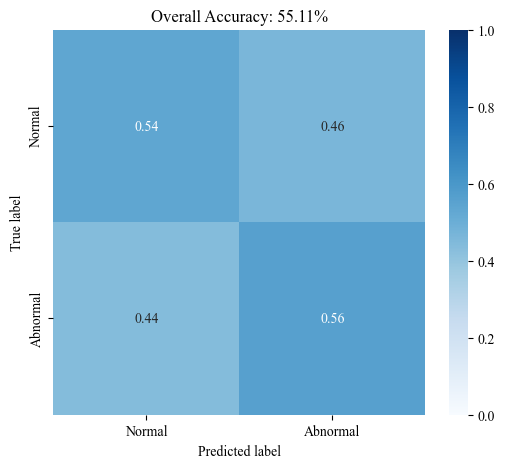

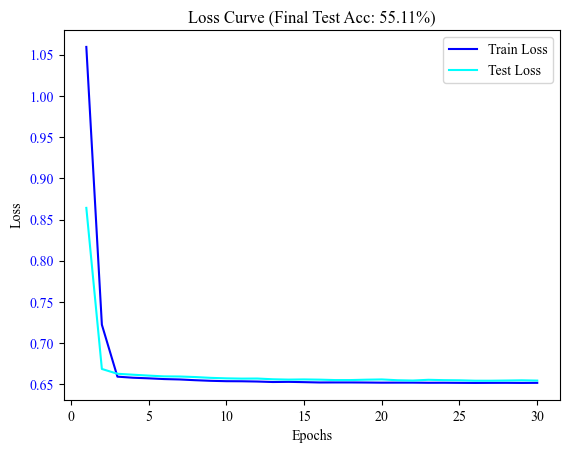

2/5th Time Epoch: 30/30

Test Accuracy: 59.28%
Average Test Loss: 0.6603


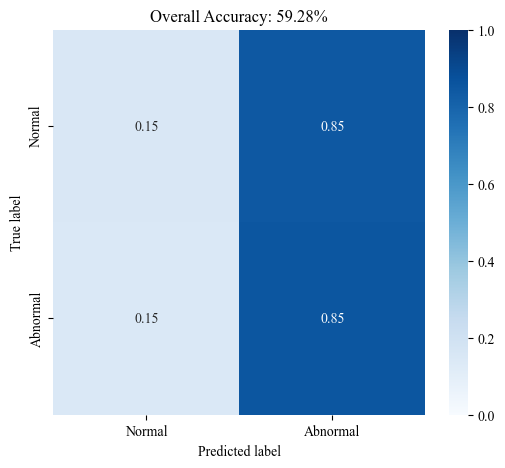

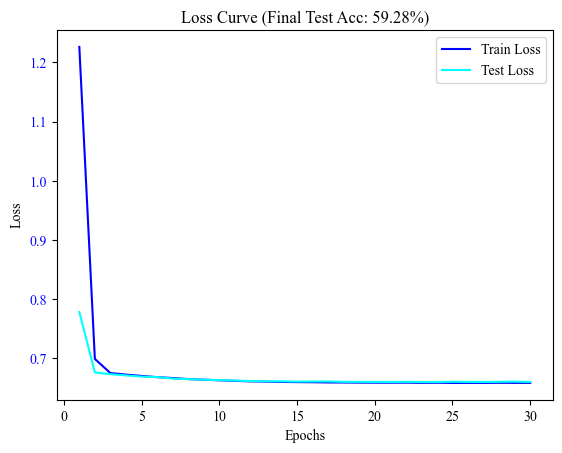

3/5th Time Epoch: 30/30

Test Accuracy: 59.10%
Average Test Loss: 0.6524


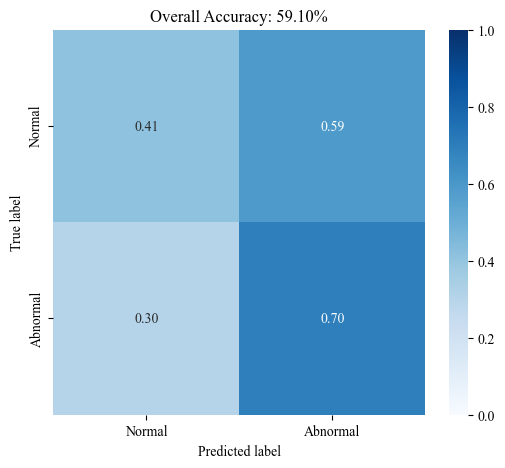

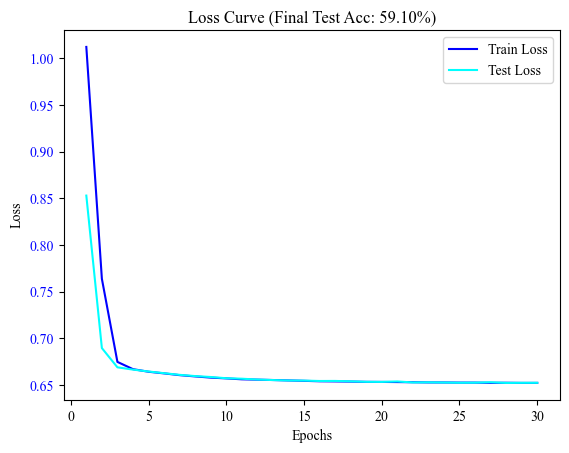

4/5th Time Epoch: 30/30

Test Accuracy: 47.61%
Average Test Loss: 0.6563


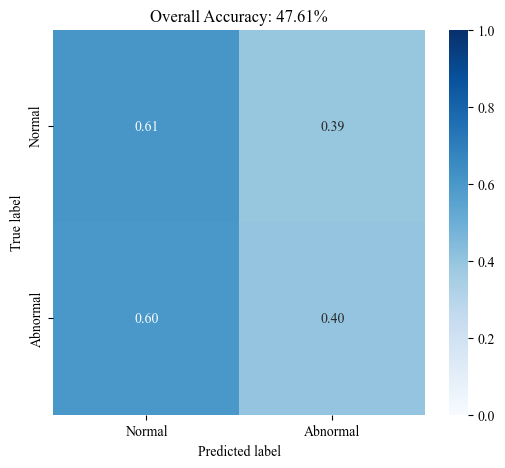

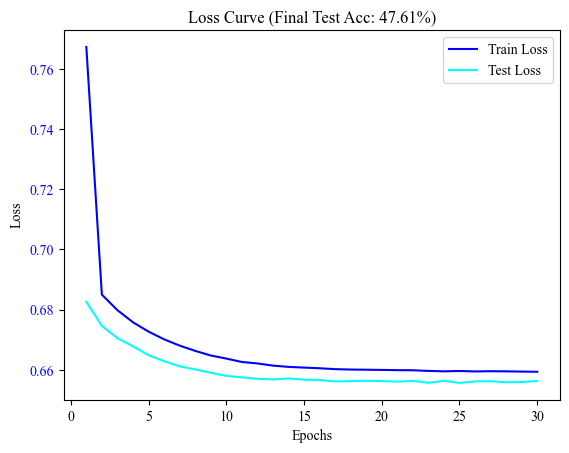

5/5th Time Epoch: 30/30

Test Accuracy: 54.42%
Average Test Loss: 0.6494


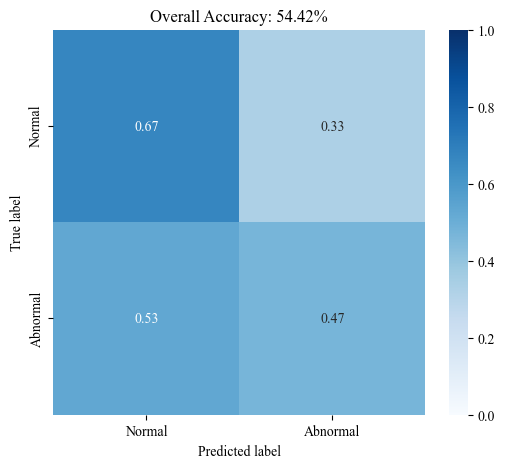

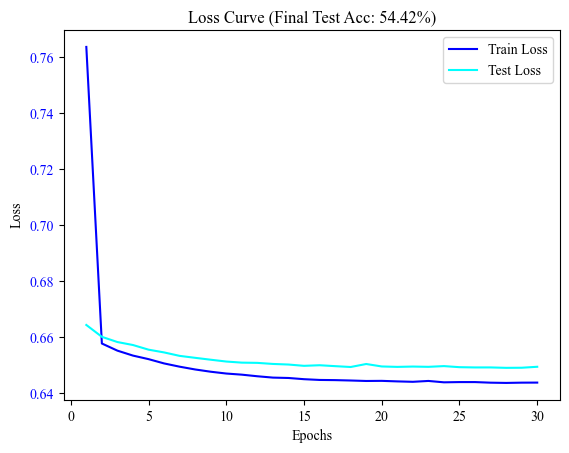

In [53]:
input_dim = 6
leverage = 4  # 圧縮倍率
max_epochs = 30
lr = 1e-4 #学習率

num_try = 5 #

All_last_loss = []
All_loss_test = []
All_pro_time = []
All_test_acc = []

for num_times in range(num_try): 
    train_dataloader, test_dataloader, num_pos, num_neg = get_new_dataloader(X_scaled,y_origin)
    model = EncoderClassifier(input_dim,leverage).to(device)
    #pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_train_ = []
    loss_test_ = []
    pro_time_ = []

    for epoch in range(max_epochs):
        model.train()
        epoch_loss_train = 0
        sys.stderr.write('\r%d/%dth Time Epoch: %d/%d' % (num_times+1,num_try, epoch+1, max_epochs)) 
        sys.stderr.flush()

        start_time1 = time.time()
        for batch_X, batch_Y in train_dataloader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            batch_Y = batch_Y.view(-1, 1)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()
            optimizer.step()

            epoch_loss_train += loss.item()

        epoch_loss_train /= len(train_dataloader)
        loss_train_.append(epoch_loss_train)
        end_time1 = time.time()
        pro_time_.append(end_time1-start_time1)

        # テスト損失計算
        model.eval()
        with torch.no_grad():
            all_preds = []
            all_labels = []
            correct = 0
            total = 0
            loss_test = 0.0

            for batch_x, batch_y in test_dataloader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                batch_y = batch_y.view(-1, 1)
                outputs = model(batch_x).to(device)  # 出力は sigmoid による確率

                predicted = (outputs > 0.5).float()  # しきい値 0.5 による2値化
                loss = criterion(outputs, batch_y)
                loss_test += loss.item()

                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
                all_preds.extend(predicted.cpu().numpy().astype(int))
                all_labels.extend(batch_y.cpu().numpy().astype(int))

        loss_test_avg = loss_test / len(test_dataloader)
        loss_test_.append(loss_test_avg)
    All_loss_test.append(loss_test_)
    Test_acc = 100 * correct / total
    print(f"Test Accuracy: {Test_acc:.2f}%")
    print(f"Average Test Loss: {loss_test_avg:.4f}")

    #  混同行列
    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # 行ごとに割合化
    Last_loss_test = loss_test_[-1]
    All_last_loss.append(Last_loss_test)
    Test_acc = 100 * correct / total
    All_test_acc.append(Test_acc)
    # ラベル名（2値）
    class_names = ['Normal', 'Abnormal']

    # 混同行列ヒートマップ表示
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names, vmin=0.0, vmax=1.0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Overall Accuracy: {Test_acc:.2f}%")
    plt.show()

    # 損失曲線の可視化（loss_train_ と loss_test_ がある前提）
    fig, ax1 = plt.subplots()
    ax1.plot(range(1, len(loss_train_) + 1), loss_train_, label="Train Loss", color='blue')
    ax1.plot(range(1, len(loss_test_) + 1), loss_test_, label="Test Loss", color='cyan')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend()
    plt.title(f'Loss Curve (Final Test Acc: {Test_acc:.2f}%)')
    plt.show()

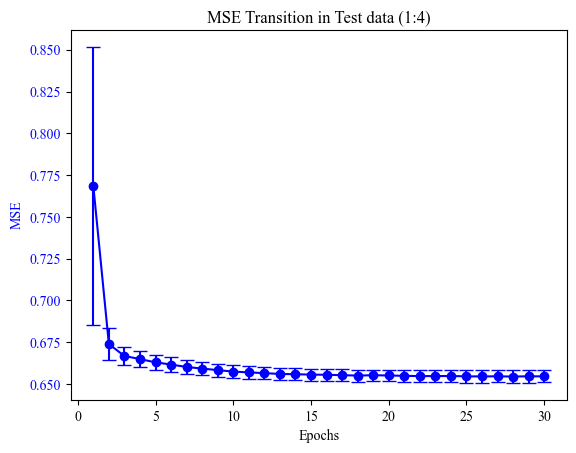

In [54]:
epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

# 各エポックごとに平均と標準偏差を計算
mean_loss = np.mean(All_loss_test, axis=0)
std_loss = np.std(All_loss_test, axis=0)

# グラフの描画
fig, ax1 = plt.subplots()

# 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
ax1.errorbar(
    x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
    fmt='-o', color='blue', ecolor='blue', capsize=5, 
)

# 軸ラベルやタイトルの設定
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.title('MSE Transition in Test data (1:%d)' % leverage)


plt.show()

In [55]:
import csv
ACC_mean = np.mean(All_test_acc)
ACC_best = np.max(All_test_acc)
ACC_bestID = np.argmax(All_test_acc)+1
ACC_worst = np.min(All_test_acc)
ACC_worstID = np.argmin(All_test_acc)+1

LOSS_mean = np.mean(All_last_loss)
LOSS_best = np.min(All_last_loss)
LOSS_bestID = np.argmin(All_last_loss)+1
LOSS_worst = np.max(All_last_loss)
LOSS_worstID = np.argmax(All_last_loss)+1

data = {
        "": ["ACC", "LOSS"],
    "Average": [ACC_mean, LOSS_mean],
    "Best ID": [ACC_bestID, LOSS_bestID],
    "Best": [ACC_best, LOSS_best],
    "Worst ID": [ACC_worstID, LOSS_worstID],
    "Worst": [ACC_worst, LOSS_worst],
}

df = pd.DataFrame(data)

print(df)


           Average  Best ID       Best  Worst ID      Worst
0   ACC  55.101101        2  59.278219         4  47.606859
1  LOSS   0.654578        5   0.649449         2   0.660256


In [56]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoMotive_data_001','texts') 
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'MLP_LI_Class00_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_loss_test)

C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoMotive_data_001\texts
